In [1]:
import re, os
from io import StringIO
import pandas
import numpy as np
import open3d as o3d # should be the latest build (official release of 0.10.0 does not support .orient_normals_consistent_tangent_plane)
import pyvista as pv # used only for visualization

In [2]:
# .cosmo file from DMol3  
filename = "BSYNRYMUTXBXSQ-UHFFFAOYSA-N" + ".cosmo"
basename = os.path.splitext(os.path.basename(filename))[0]

#output path
if not os.path.isdir("cosmo_vis"):
    os.makedirs("cosmo_vis")

In [3]:
# from to_sigma.py, usnistgov/COSMOSAC
def get_seg_DataFrame(COSMO_contents):
    # Read in the information.  Look for (X, Y, Z), and search to the end of the line, then capture until 
    # you get to a pair of two end-of-line characters, or an eol character followed by the end of string
    sdata = re.search(r"\(X, Y, Z\)[\sa-zA-Z0-9\[\]/]+\n(.+)(\n\n|$)", COSMO_contents, re.DOTALL).group(1).rstrip()
    # Annotate the columns appropriately with units(!)
    return pandas.read_csv(StringIO(sdata), names=['n','atom','x / a.u.','y / a.u.','z / a.u.','charge / e','area / A^2','charge/area / e/A^2','potential'],sep=r'\s+',engine= 'python')

inpath = "cosmo/" + filename
COSMO_contents = open(inpath).read()

# parse the COSMO file and get metadata
df = get_seg_DataFrame(COSMO_contents)
xyz=df.loc[:, ["x / a.u.", "y / a.u.", "z / a.u."]].values #x, y, z
v = df["charge/area / e/A^2"].values # charge / area

display(df)


,n,atom,x / a.u.,y / a.u.,z / a.u.,charge / e,area / A^2,charge/area / e/A^2,potential
0,1,1,-0.50918,4.43218,-2.56299,0.00004,0.09291,0.00048,-0.01367
1,2,1,-1.29632,2.88878,-3.09715,-0.00004,0.09291,-0.00040,-0.01607
2,3,1,-0.87428,3.76155,-2.91548,0.00069,0.23228,0.00296,-0.01405
3,4,1,-0.05080,4.06923,-2.88284,0.00043,0.13937,0.00311,-0.01910
4,5,1,1.61406,0.50522,3.41053,0.00066,0.13937,0.00477,-0.06399
...,...,...,...,...,...,...,...,...,...
820,821,20,-5.50488,-5.06731,3.74706,-0.00052,0.25772,-0.00203,-0.02822
821,822,13,-3.12103,-6.26559,3.72820,0.00619,0.63614,0.00974,-0.09167
822,823,13,-4.15132,-4.88221,4.33727,0.00636,0.63614,0.00999,-0.09963
823,824,16,5.56195,6.44828,1.28392,-0.00034,0.14580,-0.00234,0.04885


In [4]:
# DataFrame -> open3d.geometry.PointCloud
intensity = np.tile((v-v.min())/(v.max()-v.min()),(3,1)).transpose()
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
pcd.colors = o3d.utility.Vector3dVector(intensity)

In [5]:
# estimate normal vectors from point cloud
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=3*avg_dist, max_nn=30))
pcd.orient_normals_consistent_tangent_plane(k=10) # supported in the latest ver. (not included by 0.10.0)

# convert to surface mesh using Ball-Pivoting Algorithm
radii = [ 2.0,  0.4, 0.2]
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector(radii))

# PLY: polygonal file format
# for output filetypes see http://www.open3d.org/docs/release/tutorial/Basic/file_io.html
o3d.io.write_triangle_mesh("cosmo_vis/"+"mesh_" + basename + ".ply", bpa_mesh, write_ascii=True)
o3d.io.write_point_cloud("cosmo_vis/"+"pcd_" + basename + ".ply", pcd, write_ascii=True)

True

In [6]:
# from to_sigma.py, usnistgov/COSMOSAC
def get_atom_DataFrame(COSMO_contents):
    # Read in the information
    sdata = re.search(r"!DATE[a-zA-Z0-9:\s]+\n(.+)end\s+\nend", COSMO_contents, re.DOTALL).group(1)
    # Annotate the columns appropriately with units(!)
    return pandas.read_csv(StringIO(sdata), names=['atomidentifier','x / A','y / A','z / A','?1','?2','?3','atom','?4'],sep=r'\s+',engine = 'python')

inpath = "cosmo/" + filename
COSMO_contents = open(inpath).read()

# parse the COSMO file and get metadata
df_atom = get_atom_DataFrame(COSMO_contents)
display(df_atom)
xyz_atom=df_atom.loc[:, ["x / A", "y / A", "z / A"]].values #x, y, z
pcd_atom = o3d.geometry.PointCloud()
pcd_atom.points = o3d.utility.Vector3dVector(xyz_atom)
o3d.io.write_point_cloud("cosmo_vis/"+"pcd_atom_" + basename + ".ply", pcd_atom, write_ascii=True)

,atomidentifier,x / A,y / A,z / A,?1,?2,?3,atom,?4
0,C,0.054855,1.089609,0.166156,UNK1,1,xx,C,0.0
1,C1,0.252523,-0.172881,-0.433598,UNK1,1,xx,C,0.0
2,C2,1.180351,1.917549,0.340309,UNK1,1,xx,C,0.0
3,C3,-1.288894,1.556430,0.585841,UNK1,1,xx,C,0.0
4,C4,1.522095,-0.578849,-0.841025,UNK1,1,xx,C,0.0
5,O,-0.813285,-1.024906,-0.729532,UNK1,1,xx,O,0.0
6,C5,2.449779,1.513224,-0.062900,UNK1,1,xx,C,0.0
7,O1,-1.268049,2.847990,1.072178,UNK1,1,xx,O,0.0
8,O2,-2.339086,0.922606,0.528359,UNK1,1,xx,O,0.0
9,C6,2.620585,0.259903,-0.656691,UNK1,1,xx,C,0.0


True

In [7]:
# vizualize using open3d
#o3d.visualization.draw_geometries([bpa_mesh])

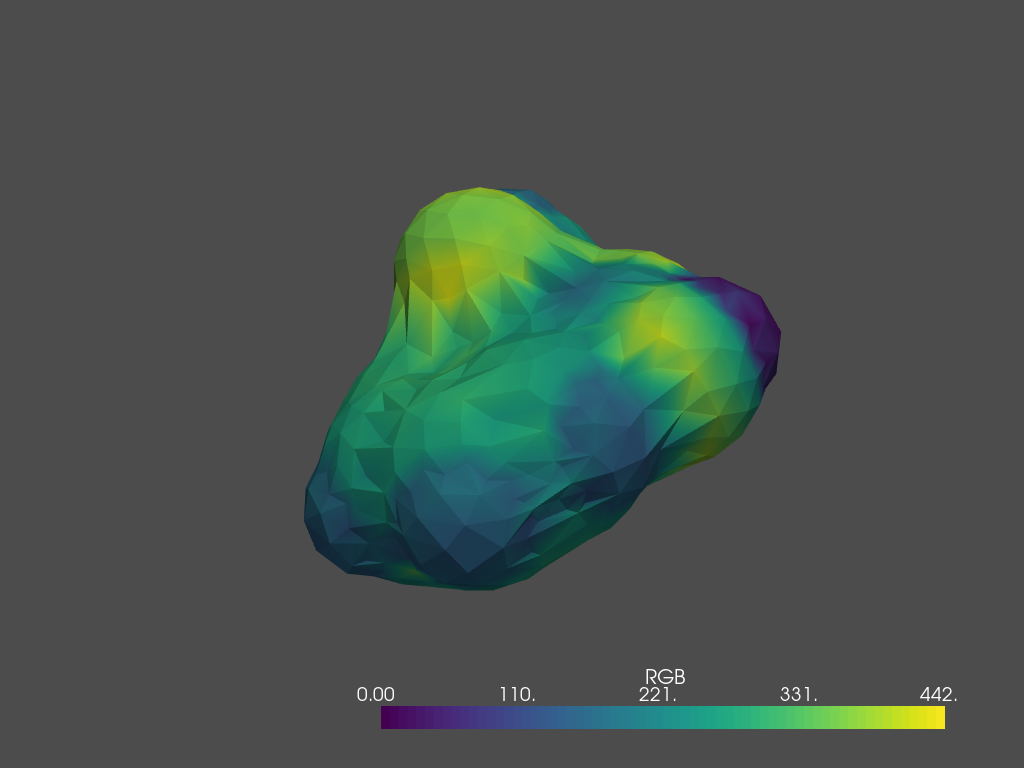

In [8]:
# vizualize using pyvista
mesh = pv.read("cosmo_vis/"+"mesh_" + basename + ".ply")
cpos = mesh.plot()